<a href="https://colab.research.google.com/github/veritaem/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/Copy_of_LS_DS1_234_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Ridge Regression

Regularize your way to a better tomorrow.

# Lecture

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

## Stop and think - what are ways to address these issues?

Let's examine in the context of housing data.

In [0]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [0]:
?scale

In [0]:
df.shape

(506, 14)

In [0]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

21.894831181729206

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

22.347018673376052
26.273991426429014


Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

## Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...


In [0]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

21.895862166800143

In [0]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

26.192201358877668

In [0]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

How to tune alpha? For now, let's loop and try values.

(For longterm/stretch/next week, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).)

In [0]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 26.273991426429053
1 26.192201358877668
2 26.118328007697226
3 26.051117952293595
4 25.989569283205444
5 25.93287356811407
6 25.880372753122625
7 25.831526788692837
8 25.785889053385123
9 25.743087513207442
10 25.702810145277628
11 25.66479356379559
12 25.628814073392263
13 25.59468057863174
14 25.56222892458644
15 25.53131734932431
16 25.50182280665663
17 25.473637974726547
18 25.44666880864133
19 25.420832527348388
20 25.396055949160893
21 25.372274108781504
22 25.349429102822004
23 25.327469121742823
24 25.30634763462536
25 25.286022699825878
26 25.266456379775086
27 25.24761424230921
28 25.229464934192976
29 25.211979815108453
30 25.19513264248022
31 25.178899299197408
32 25.163257557659424
33 25.14818687468406
34 25.13366821272317
35 25.11968388357409
36 25.106217411385522
37 25.093253412260974
38 25.080777488180427
39 25.068776133307583
40 25.057236651039766
41 25.046147080399017
42 25.035496130566347
43 25.02527312253186
44 25.015467936977434
45 25.006070967630855
46 24.997073

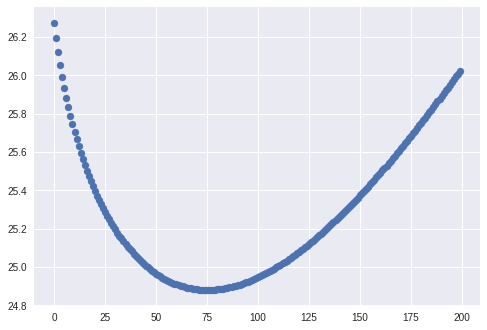

In [0]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

## What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

In [0]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

(10, 14)


1.0

In [0]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

0.9760119331942763

In [0]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

103.04429449784261

In [0]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

41.79869373639458

In [0]:
# e.g. (x1^2 + x2^2 + ...) * alpha is the extra penalty from Ridge

## And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

## Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

```
Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression
```

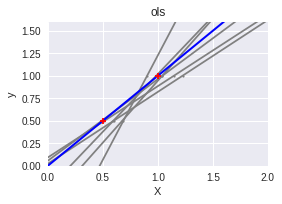

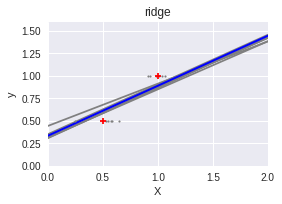

In [0]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

# Assignment

Following is data describing characteristics of blog posts, with a target feature of how many comments will be posted in the following 24 hours.

https://archive.ics.uci.edu/ml/datasets/BlogFeedback

Investigate - you can try both linear and ridge. You can also sample to smaller data size and see if that makes ridge more important. Don't forget to scale!

Focus on the training data, but if you want to load and compare to any of the test data files you can also do that.

Note - Ridge may not be that fundamentally superior in this case. That's OK! It's still good to practice both, and see if you can find parameters or sample sizes where ridge does generalize and perform better.

When you've fit models to your satisfaction, answer the following question:

```
Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
```

You can create whatever plots, tables, or other results support your argument. In this case, your target audience is a fellow data scientist, *not* a layperson, so feel free to dig in!

#making an import button since googles gives me ajida and loading data

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving blogData_train.csv to blogData_train.csv
User uploaded file "blogData_train.csv" with length 65095322 bytes


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [0]:
data = 'blogData_train.csv'

In [4]:
df = pd.read_csv(data)
df.head()

,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0.1,377.0,3.0,...,0.0.229,1.0.1,0.0.230,0.0.231,0.0.232,0.0.233,0.0.234,0.0.235,0.0.236,1.0.2
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(52396, 281)

In [6]:
df.isna().sum().sum()

0

#scale and initial LR and RR

In [0]:
X = df.drop('1.0.2', axis = 1)
y = df['1.0.2']
X = scale(X)

In [9]:
lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

903.1738813033419

In [10]:
ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

903.2990528482154

In [0]:
y

#Sampling

In [0]:
samples = df.sample(5000, random_state = 665)

In [12]:
samples

,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0.1,377.0,3.0,...,0.0.229,1.0.1,0.0.230,0.0.231,0.0.232,0.0.233,0.0.234,0.0.235,0.0.236,1.0.2
21373,3.715000,9.447422,0.0,101.0,2.0,1.795000,5.979379,0.0,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4391,13.131769,19.307571,0.0,159.0,6.0,6.240072,9.528322,0.0,92.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50813,1.190476,1.867493,0.0,5.0,0.0,0.523810,0.957131,0.0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31144,0.054945,0.227873,0.0,1.0,0.0,0.021978,0.146612,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40943,3.261538,15.332497,0.0,159.0,0.0,1.409231,9.702430,0.0,144.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
46286,9.080925,11.228800,0.0,97.0,6.0,3.641618,6.549403,0.0,97.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2066,123.869190,129.566220,0.0,1065.0,87.0,43.328970,62.774147,0.0,491.0,19.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,12.713147,37.326775,0.0,222.0,1.0,5.669322,23.756027,0.0,222.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32922,56.512093,77.442830,0.0,438.0,32.0,19.296530,49.221344,0.0,432.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
7573,7.598214,9.585806,0.0,76.0,4.0,3.220982,5.443936,0.0,44.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0


In [0]:
sampX = samples.drop('1.0.2', axis = 1)
sampy = samples['1.0.2']

In [0]:
sampX2 = samples2.drop(280, axis = 1)
sampy2 = samples2[280]

#Ridge analysis(samples)

In [50]:
sampX2_train, sampX2_test, sampy2_train, sampy2_test = train_test_split(sampX2, sampy2, random_state=736)
samp_lin_reg_split2 = LinearRegression().fit(sampX2_train, sampy2_train)
print(mean_squared_error(sampy2, samp_lin_reg_split2.predict(sampX2)))
print(mean_squared_error(sampy2_test, samp_lin_reg_split2.predict(sampX2_test)))

1.9578662196964416e+20
7.831464878785765e+20


In [29]:
sampX_train, sampX_test, sampy_train, sampy_test = train_test_split(sampX, sampy, random_state=43)
samp_lin_reg_split = LinearRegression().fit(sampX_train, sampy_train)
print(mean_squared_error(sampy, samp_lin_reg_split.predict(sampX)))
print(mean_squared_error(sampy_test, samp_lin_reg_split.predict(sampX_test)))

8.018915308324245e+19
3.207566123329698e+20


In [30]:
samp_ridge_reg_split = Ridge().fit(sampX_train, sampy_train)
mean_squared_error(sampy_test, samp_ridge_reg_split.predict(sampX_test))

0.6719585370364553

In [40]:
samp_alphas = []
samp_mses = []

for samp_alpha in range(0, 50, 1):
  samp_ridge_reg_split = Ridge(alpha=samp_alpha).fit(sampX_train, sampy_train)
  samp_mse = mean_squared_error(sampy_test, samp_ridge_reg_split.predict(sampX_test))
  print(samp_alpha, samp_mse)
  samp_alphas.append(samp_alpha)
  samp_mses.append(samp_mse)

0 8.34579912284143e+27
1 0.6719585370364553
2 0.6719036873139598
3 0.6718402173160928
4 0.6717669720970539
5 0.671687451040279
6 0.6716040674890044
7 0.6715185141480595
8 0.6714320115343959
9 0.6713454479390667
10 0.67125946940009
11 0.671174542514161
12 0.6710909999641776
13 0.6710090740839217
14 0.670928921828057
15 0.6708506434624818
16 0.6707742966247094
17 0.6706999069487423
18 0.6706274761266019
19 0.6705569880471568
20 0.67048841348531
21 0.670421713692727
22 0.6703568431521972
23 0.6702937516922874
24 0.670232386110635
25 0.6701726914184097
26 0.6701146117916763
27 0.6700580912953602
28 0.6700030744303408
29 0.6699495065427425
30 0.6698973341257151
31 0.6698465050373036
32 0.6697969686528489
33 0.6697486759663559
34 0.669701579652188
35 0.6696556340960186
36 0.6696107954020892
37 0.6695670213823426
38 0.6695242715318254
39 0.6694825069938424
40 0.6694416905176126
41 0.6694017864105919
42 0.6693627604871768
43 0.6693245800151308
44 0.6692872136607887
45 0.6692506314338516
46 0.6

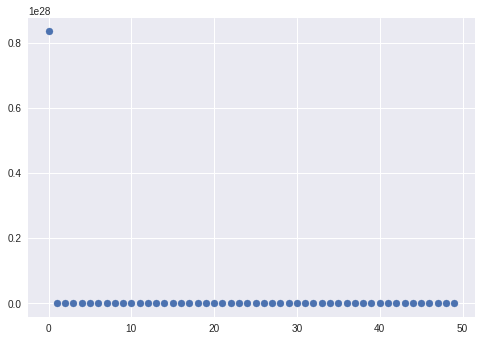

In [41]:
plt.scatter(samp_alphas, samp_mses);


In [35]:
samp_alphas = []
samp_mses = []

for samp_alpha in range(0, 5000, 1):
  samp_ridge_reg_split = Ridge(alpha=samp_alpha).fit(sampX_train, sampy_train)
  samp_mse = mean_squared_error(sampy_test, samp_ridge_reg_split.predict(sampX_test))
  print(samp_alpha, samp_mse)
  samp_alphas.append(samp_alpha)
  samp_mses.append(samp_mse)

0 8.34579912284143e+27
1 0.6719585370364553
2 0.6719036873139598
3 0.6718402173160928
4 0.6717669720970539
5 0.671687451040279
6 0.6716040674890044
7 0.6715185141480595
8 0.6714320115343959
9 0.6713454479390667
10 0.67125946940009
11 0.671174542514161
12 0.6710909999641776
13 0.6710090740839217
14 0.670928921828057
15 0.6708506434624818
16 0.6707742966247094
17 0.6706999069487423
18 0.6706274761266019
19 0.6705569880471568
20 0.67048841348531
21 0.670421713692727
22 0.6703568431521972
23 0.6702937516922874
24 0.670232386110635
25 0.6701726914184097
26 0.6701146117916763
27 0.6700580912953602
28 0.6700030744303408
29 0.6699495065427425
30 0.6698973341257151
31 0.6698465050373036
32 0.6697969686528489
33 0.6697486759663559
34 0.669701579652188
35 0.6696556340960186
36 0.6696107954020892
37 0.6695670213823426
38 0.6695242715318254
39 0.6694825069938424
40 0.6694416905176126
41 0.6694017864105919
42 0.6693627604871768
43 0.6693245800151308
44 0.6692872136607887
45 0.6692506314338516
46 0.6

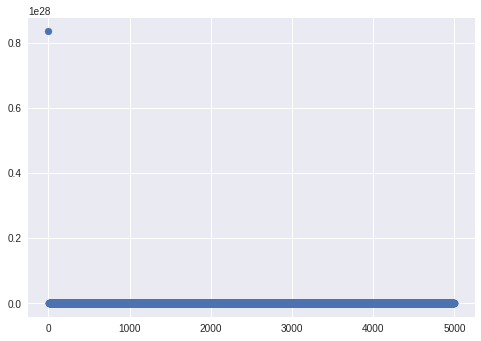

In [39]:
plt.scatter(samp_alphas, samp_mses);

#Ridge analysis(full)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

905.6176762742731
964.5161992596546


In [15]:
ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

964.0949551714053

In [0]:
alphas = []
mses = []

for alpha in range(0, 4000, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  #print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

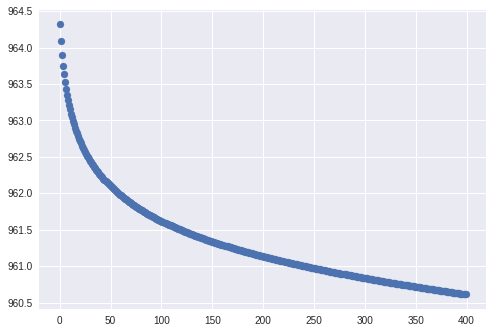

In [25]:
plt.scatter(alphas, mses);

In [55]:
ridge_reg_split = Ridge(alpha = 3050).fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

958.8393309562739

In [0]:
dfX=pd.DataFrame(X)

In [82]:
X2 = dfX.drop(dfX.columns[:50], axis = 1)
X2.shape

(52396, 230)

In [83]:
y.shape

(52396,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=43)

In [84]:
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X2)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

1080.7404163792016
1140.6721961182395


In [93]:
ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

1140.5074126495397

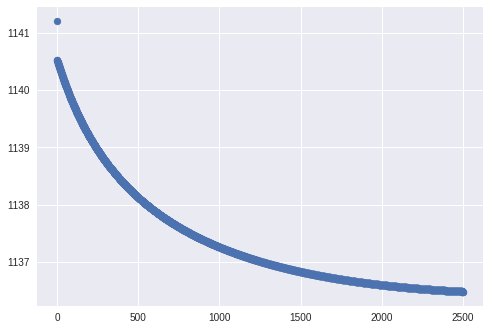

In [95]:
alphas = []
mses = []

for alpha in range(0, 2500, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  #print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)
  
plt.scatter(alphas, mses);

In [99]:
ridge_reg_split = Ridge(alpha = 3500).fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

1136.4513601082515

# Resources and stretch goals

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022

Stretch goals:
- Revisit past data you've fit OLS models to, and see if there's an `alpha` such that ridge regression results in a model with lower MSE on a train/test split
- Yes, Ridge can be applied to classification! Check out [sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), and try it on a problem you previous approached with a different classifier (note - scikit LogisticRegression also automatically penalizes based on the $L^2$ norm, so the difference won't be as dramatic)
- Implement your own function to calculate the full cost that ridge regression is optimizing (the sum of squared residuals + `alpha` times the sum of squared coefficients) - this alone won't fit a model, but you can use it to verify cost of trained models and that the coefficients from the equivalent OLS (without regularization) may have a higher cost